<a href="https://colab.research.google.com/github/RoFree/1D_FDMethodThermal-EM/blob/main/Thermal_Modeling_of_Coaxial_line_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The code below implements equations from the paper while also implementing a common FD method 1D temperature solver. The key functions in this library are OneDFiniteThermalSolver which is the 1D FD Thermal solver and OneDFiniteEMLossSolver which uses the FD Thermal Solver to approximate loss on the transmission line (also using the FD method).

In [ ]:
#Created by Ron Freeman 2021. All rights reserved.
#Lessons learned:
# - verify equations found online
# - use SI standard units to avoid confusion later on
#     - apply conversion factors in the function
# - use published coax data to verify the model


import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
#units are m, K, dB, W*m/K
ConductivityOfCopperSI = 5.98e+7
ConductivityOfCopperIACS = 100.0
PermeabilityOfFreeSpace = 4*np.pi*1E-7

#thermodynamics utility equations
def R_tCalc(delta_L, t_conduct, areaConduct):
  return delta_L/(t_conduct*areaConduct)

def R_tCalc_wTemp (delta_L, t_conduct, areaConduct, temp):
  return delta_L/(t_conduct(temp)*areaConduct)

def area_calc(Dout, Dinner):
  return np.pi*pow(Dout/2,2)-np.pi*pow(Dinner/2, 2)

def HeatFlowTotal(Thot, Tcold, R_t_int, L, a):
  return ((Thot-Tcold)*a)/(R_t_int*L)



#utility functions to calculate loss
def AdB_calc(R_m, z_0, Dout, Dinner, L): #R_m is skin resistance
  return (1.38*(R_m/z_0)*((1/Dout)+(1/Dinner)))*L

def AdB_calcv2(R_m_out, R_m_inner, z_0, Dout, Dinner, L): #R_m is skin resistance
  return (1.38*(1/z_0)*((R_m_out/Dout)+(R_m_inner/Dinner)))*L

def AdB_calcv3(e_cond_inner, perm_inner, e_cond_outer, perm_outer, Dinner, Douter, Dk, f, Z0):
  Res_per_len = (8.686/(2*138))*np.sqrt((f*PermeabilityOfFreeSpace*Dk)/np.pi)*((np.sqrt(e_cond_outer*perm_outer)/Douter)+(np.sqrt(e_cond_inner*perm_inner)/Dinner))*1/(np.log10(Douter/Dinner))
  loss_per_len = Res_per_len/(2*Z0)
  return loss_per_len

def R_m_calc(f, e_cond_cu, e_cond): #not sure what e_cond_cu is (the sigma_cu in equation 7) NOTES: sigma_cu is the electrical conductivity of copper at room temperature (constant). The other conductivity is the conductivity of the conductor (either copper inner conductor or ss outer conductor) 
  return 0.0034*np.sqrt(f)*np.sqrt(e_cond_ref/(1/e_cond))

def Z0_calc(epsilon, Dout, Dinner):
  return (138/np.sqrt(epsilon))*np.log10(Dout/Dinner)

def nTemp_calc(NF, Tcold, Tgradient):#Tp is the temperature of the device, G is the gain, NF is the noise figure
  p_ratio_calc =lambda NFr: 1/pow(10, NFr/10)
  total_noise_in = Tcold*p_ratio_calc(NF[0])
  total_noise_nseg = 0
  total_noise_nseg_array = []
  prod = []
  for i in range(len(NF)):
    prod.append(p_ratio_calc(NF[i]))
  for i in range(len(NF)):
    total_noise_nseg = total_noise_nseg + Tgradient[i]*(1-p_ratio_calc(NF[i]))
    total_noise_nseg_array.append(total_noise_nseg)
  #return total_noise_in+total_noise_nseg*np.prod(prod)
  return total_noise_in+total_noise_nseg*np.prod(prod), total_noise_nseg_array

def NF_calc(loss):
  return 10*np.log10(pow(10,loss/10))

def innerConductorLoss(dInner, f, dk, Tgradient, e_cond): #frequency in gigahertz
  final = []
  wav_len = 2.99e+8/(np.sqrt(Dk)*f*1e+9)
  for i in range(len(Tgradient)):
    final.append((e_cond(Tgradient[i]))/(wav_len*np.pi*2*(dInner+wav_len*(np.exp(-dInner/wav_len)-1))))
  return final


#approximating the resistivity given temperature using NIST data
# https://srd.nist.gov/JPCRD/jpcrd155.pdf

T0_cu = np.array([1, 4, 7, 10, 15, 20 ,25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100, 125, 150, 175, 200, 225, 250, 273.15, 293, 300, 350, 400, 500, 600, 700, 800])
r0_cu = np.array([0.002, 0.002, 0.002, 0.00202, 0.00218, 0.00280, 0.00449, 0.00828, 0.0147, 0.0239, 0.0358, 0.0518, 0.0727, 0.0971, 0.154, 0.215, 0.281, 0.348, 0.522, 0.699, 0.874, 1.046, 1.217, 1.387, 1.543, 1.678, 1.725, 2.063, 2.402, 3.090, 3.792, 4.514, 5.262])*1e-8

e_cond_cu = np.polynomial.chebyshev.Chebyshev.fit(T0_cu[:-7],r0_cu[:-7],4) #fitting the conductivity to a 4th degree polynomial
#plt.figure()
#plt.plot(T0[:-7], (r0_cu[:-7]-e_cond_cu(T0[:-7]))) #plots error in the approximation within 1% accuracy

#resistivity of BeCu
e_cond_BeCu = lambda x: 8.31*1e-8+x*0
T0_BeCu_cond = [273, 192, 75.8, 19.6, 4]
r0_BeCu_C17200 = np.array([105.1, 96.8, 84.9, 81.8, 82.1])*1e-9
e_cond_BeCu_C17200 = np.polynomial.chebyshev.Chebyshev.fit(T0_BeCu_cond, r0_BeCu_C17200, 4)

#approimating electrical resistivity of 304 stainless steel
T0_SUS304 = np.array([2,3,4,5,6,7,8,9,10,12,14,16,18,20,25,30,35,40,45,50,60,70,80,90,100,150,200,250,300,400,500, 600,700,800])
r0_SUS304 = np.array([593, 593, 593, 594,594,594,594,594,594,594,594,593,593,593,592,592,593,595,597,599,606,613,622,630,639,683,724,767,810,885,944,997,1045,1088])*1e-9

e_cond_SUS304 = np.polynomial.chebyshev.Chebyshev.fit(T0_SUS304[:-7],r0_SUS304[:-7],4) #fitting the conductivity to a 4th degree polynomial

#approximating thermal resistance from the heat flow of coax
T0_coax = [188.5, 48.5, 12]
q_coax_SS_BeCu_data = [3.55e-5, 1.86e-5, 1.44e-6] #W/cmK coax 0.085 diameter
q_coax_SS_BeCu_data2 = [3.55e-1, 1.86e-1, 1.44e-2] #W/cmK coax 0.085 diameter
q_coax_SS_BeCu = np.polynomial.chebyshev.Chebyshev.fit(T0_coax,q_coax_SS_BeCu_data2,2) #fitting the conductivity to a 2nd degree polynomial
"""""
y = []
for i in range(len(T0_coax)):
  y.append(q_coax_SS_BeCu(T0_coax[i]))
plt.figure()
plt.plot(T0_coax, y)
"""""

#approximating the thermal conductivity of stainless steel (304)
T0_SUS304 = [40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300]
tConduct_SUS304_data = np.array([4.670, 5.730, 6.647, 7.435, 8.114, 8.705, 9.224, 10.101, 10.834, 11.479, 12.071, 12.633, 13.178, 13.714, 14.247, 14.779, 15.309])
tConduct_SUS304 = np.polynomial.chebyshev.Chebyshev.fit(T0_SUS304, tConduct_SUS304_data, 4) #fitting the conductivity to a 4th degree polynomial
tConduct_SUS304_integral = np.polynomial.chebyshev.chebint(tConduct_SUS304)

#approximating the thermal conductivity of BeCu and specific heat https://nvlpubs.nist.gov/nistpubs/Legacy/MONO/nistmonograph177.pdf, C17510
T0_BeCu = [76, 77.2, 78.46, 96, 106, 192.7, 215.4, 276, 284, 299]
tConduct_BeCu_data = np.array([132.5, 133, 133.5, 146.7, 153.6, 202.4, 213.5, 232.5, 235.4, 230]) #not sure this is correct
"""
T0_BeCu = [50, 60, 70, 80, 90, 100, 120, 300]
tConduct_BeCu_data = np.array([26.2, 30.42, 34.08, 37.15, 39.6, 41.41, 43.12, 85])
"""
tConduct_BeCu = np.polynomial.chebyshev.Chebyshev.fit(T0_BeCu, tConduct_BeCu_data, 4) #fitting the conductivity to a 4th degree polynomial
tConduct_BeCu_integral = np.polynomial.chebyshev.chebint(tConduct_BeCu)

T0_BeCu_SpecificHeat = [83.2, 99.4, 113, 125, 143, 182, 212, 242, 273, 297, 345]
SpecificHeat_BeCu_data = [226, 261, 269, 297, 328, 359, 371, 361, 391, 396, 404]
SpecificHeat_BeCu = np.polynomial.chebyshev.Chebyshev.fit(T0_BeCu_SpecificHeat, SpecificHeat_BeCu_data, 4)
e_cond_ref = (ConductivityOfCopperSI) 



#1D thermal solver using the FD method
def populateInitialState(Thot, Tcold, L, n_seg):
  y = lambda x : x*(Tcold-Thot)/L + Thot
  t = []
  for i in range(n_seg):
    t.append(y(i*(L/n_seg)))
  return t

def sigDiff(a, b, thresh):
  assert len(a) == len(b)
  for i in range(len(a)):
    if not abs(a[i]-b[i]) <= thresh:
      return False
  return True

"""
Solves for the thermal gradient on the coaxial cable inner and outer conductor using an analogy to ohms law.
Clamp function takes a 2 element array in the format [distance from Thot, temperature], to add more clamps just add a dimension to the array
ie. one clamp would look like np.array([5, 300]) and two would be np.array([5, 300], [3, 300])
"""
def OneDFiniteThermalSolver_withResistancev4(Thot, Tcold, thresh, L, n_seg_i, t_conduct_outer, t_conduct_inner, Dout, Dout_in, Dinner):
  n_seg = n_seg_i
  bar_inner = populateInitialState(Thot, Tcold, L, n_seg)
  bar_outer = populateInitialState(Thot, Tcold, L, n_seg)
  final_inner= distribute_withResistancev3(bar_inner, L, n_seg, t_conduct_inner, np.pi*(Dinner/2)**2)
  final_outer = distribute_withResistancev3(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
  counter = 0
  while not sigDiff(bar_inner, final_inner, thresh):
    if counter > 100:
      n_seg = n_seg + 10
      bar_inner = populateInitialState(Thot, Tcold, L, n_seg)
      final_inner= distribute_withResistancev3(bar_inner, L, n_seg, t_conduct_inner, np.pi*(Dinner/2)**2)
      counter = 0
    else:
      bar_inner = final_inner
      final_inner= distribute_withResistancev3(bar_inner, L, n_seg, t_conduct_inner, np.pi*(Dinner/2)**2)
      counter = counter + 1
  n_seg = n_seg_i
  counter = 0
  while not sigDiff(bar_outer, final_outer, thresh):
    if counter > 100:
      n_seg = n_seg + 10
      bar_outer = populateInitialState(Thot, Tcold, L, n_seg)
      final_outer = distribute_withResistancev3(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
      counter = 0
    else:
      bar_outer = final_outer
      final_outer = distribute_withResistancev3(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
      counter = counter + 1
  if not len(final_inner) == len(final_outer):
    if len(final_inner) > len(final_outer):
      n_seg = len(final_inner)
      counter = 0
      bar_outer = populateInitialState(Thot, Tcold, L, n_seg)
      final_outer = distribute_withResistancev3(bar_outer, L, n_seg, t_conduct_outer, np.pi*(Dinner/2)**2)
      while counter < 100:
        bar_outer = final_outer
        final_outer = distribute_withResistancev3(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
        counter = counter + 1
    else:
      counter = 0
      n_seg = len(final_outer)
      bar_inner = populateInitialState(Thot, Tcold, L, n_seg)
      final_inner= distribute_withResistancev3(bar_inner, L, n_seg, t_conduct_inner, np.pi*(Dinner/2)**2)
      while counter < 100:
        bar_inner = final_inner
        final_outer = distribute_withResistancev3(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
        counter = counter + 1
  return final_inner, final_outer


  new = old[:]
  for i in range(1, len(old)-1):
    #new[i] = (old[i-1]+old[i+1])R_tCalc(L/n_seg, t_conduct, area)
    new[i] = (old[i-1]+old[i+1])*1/2
  return new

def distribute_withResistancev3(old, L, n_seg, t_conduct, area):
  new = old[:]
  R_total = 0
  for i in range(len(old)):
    R_total += (L/n_seg)/(t_conduct(old[i])*area)
  for i in range(1, n_seg-1):
    Q = (max(old)-min(old))/R_total
    DeltaT = Q*((L/n_seg)/(t_conduct(old[i-1])*area))
    new[i] = new[i-1]-DeltaT
  return new
###############
# Depreceated #
###############
def OneDFiniteThermalSolver_withResistancev3(Thot, Tcold, thresh, L, n_seg_i, t_conduct_inner, t_conduct_outer, Dout, Dout_in, Dinner):
  n_seg = n_seg_i
  bar_inner = populateInitialState(Thot, Tcold, L, n_seg)
  bar_outer = populateInitialState(Thot, Tcold, L, n_seg)
  final_inner= distribute_withResistancev2(bar_inner, L, n_seg, t_conduct_inner, np.pi*(Dinner/2)**2)
  final_outer = distribute_withResistancev2(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
  counter = 0
  while not sigDiff(bar_inner, final_inner, thresh):
    if counter > 100:
      n_seg = n_seg + 10
      bar_inner = populateInitialState(Thot, Tcold, L, n_seg)
      final_inner= distribute_withResistancev2(bar_inner, L, n_seg, t_conduct_inner, np.pi*(Dinner/2)**2)
      counter = 0
    else:
      bar_inner = final_inner
      final_inner= distribute_withResistancev2(bar_inner, L, n_seg, t_conduct_inner, np.pi*(Dinner/2)**2)
      counter = counter + 1
  n_seg = n_seg_i
  counter = 0
  while not sigDiff(bar_outer, final_outer, thresh):
    if counter > 100:
      n_seg = n_seg + 10
      bar_outer = populateInitialState(Thot, Tcold, L, n_seg)
      final_outer = distribute_withResistancev2(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
      counter = 0
    else:
      bar_outer = final_outer
      final_outer = distribute_withResistancev2(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
      counter = counter + 1
  if not len(final_inner) == len(final_outer):
    if len(final_inner) > len(final_outer):
      n_seg = len(final_inner)
      counter = 0
      bar_outer = populateInitialState(Thot, Tcold, L, n_seg)
      final_outer = distribute_withResistancev2(bar_outer, L, n_seg, t_conduct_outer, np.pi*(Dinner/2)**2)
      while counter < 100:
        bar_outer = final_outer
        final_outer = distribute_withResistancev2(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
        counter = counter + 1
    else:
      counter = 0
      n_seg = len(final_outer)
      bar_inner = populateInitialState(Thot, Tcold, L, n_seg)
      final_inner= distribute_withResistancev2(bar_inner, L, n_seg, t_conduct_inner, np.pi*(Dinner/2)**2)
      while counter < 100:
        bar_inner = final_inner
        final_outer = distribute_withResistancev2(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
        counter = counter + 1
  return final_inner, final_outer

def OneDFiniteThermalSolver(bar, thresh, L, n_seg, t_conduct, Dout, Dinner):
  final= distribute(bar, L, n_seg, t_conduct, area_calc(Dout, Dinner))
  while not sigDiff(bar, final, thresh):
    bar = final
    final = distribute(bar, L, n_seg, t_conduct, area_calc(Dout, Dinner))
  return final

def distribute(old, L, n_seg, t_conduct, area):
  new = old[:]
  for i in range(1, len(old)-1):
    #new[i] = (old[i-1]+old[i+1])R_tCalc(L/n_seg, t_conduct, area)
    new[i] = (old[i-1]+old[i+1])*1/2
  return new

def OneDFiniteThermalSolver_withResistance(Thot, Tcold, thresh, L, n_seg, t_conduct, Dout, Dinner):
  bar = populateInitialState(Thot, Tcold, L, n_seg)
  final= distribute_withResistancev2(bar, L, n_seg, t_conduct, area_calc(Dout, Dinner))
  counter = 0
  while not sigDiff(bar, final, thresh):
    if counter > 100:
      plot = plt.figure()
      ax = plt.axes()
      ax.plot(final)
      n_seg = n_seg + 10
      plot = plt.figure()
      ax = plt.axes()
      ax.plot(final)
      bar = populateInitialState(Thot, Tcold, L, n_seg)
      counter = 0
    else:
      bar = final
    final = distribute_withResistancev2(bar, L, n_seg, t_conduct, area_calc(Dout, Dinner))
    counter = counter + 1
  return final

def distribute_withResistancev2(old, L, n_seg, t_conduct, area):
  new = old[:]
  Q = HeatFlowTotal(max(old), min(old), R_tCalc(L/n_seg, t_conduct(mean(old)), area), L, area)
  for i in range(1, n_seg-1):
    #T2 = (T1(R2+R3)+T3(R1+R2))/(2*R2+R3+R1) where T2=T at n; T1 = T at n-1; and T3 = T at n+1
    new[i] = (old[i-1]*(R_tCalc(L/n_seg, t_conduct(old[i]), area)+R_tCalc(L/n_seg, t_conduct(old[i+1]), area))+old[i+1]*(R_tCalc(L/n_seg, t_conduct(old[i-1]), area)+R_tCalc(L/n_seg, t_conduct(old[i]), area)))/(2*R_tCalc(L/n_seg, t_conduct(old[i]), area)+R_tCalc(L/n_seg, t_conduct(old[i+1]), area)+R_tCalc(L/n_seg, t_conduct(old[i-1]), area))
  return new

def distribute_withResistance(old, L, n_seg, t_conduct, area):
  new = old[:]
  Q = HeatFlowTotal(max(old), min(old), R_tCalc(L/n_seg, t_conduct(mean(old)), area), n_seg)
  for i in range(0, n_seg):
    new[i] = old[i-1]-Q*R_tCalc(L/n_seg, t_conduct(old[i]), area)*i
  return new
def OneDFiniteThermalSolver_withResistance_constTconduct(Thot, Tcold, thresh, L, n_seg, t_conduct, Dout, Dinner):
  bar = populateInitialState(Thot, Tcold, L, n_seg)
  final= distribute_withResistance_constTconduct(bar, L, n_seg, t_conduct, area_calc(Dout, Dinner))
  while not sigDiff(bar, final, thresh):
    bar = final
    final = distribute_withResistance_constTconduct(bar, L, n_seg, t_conduct, area_calc(Dout, Dinner))
  return final
def distribute_withResistance_constTconduct(old, L, n_seg, t_conduct, area):
  new = old[:]
  Q = HeatFlowTotal(max(old), min(old), R_tCalc(L/n_seg, t_conduct, area), n_seg)
  for i in range(1, n_seg-1):
    new[i] = old[i-1]-Q*R_tCalc(L/n_seg, t_conduct, area)
  return new
###############
###############
###############




#1D noise solver factoring thermals 
PermeabilityOfFreeSpace = 4*np.pi*1E-7

def SkinDepth_calc(f, mu_R,  e_res): #e_cond in ohms/m
  return np.sqrt(e_res/(np.pi*f*PermeabilityOfFreeSpace*mu_R))

def Z0_calc(epsilon, Dout, Dinner):
  return (138/np.sqrt(epsilon))*np.log10(Dout/Dinner)

def InnerCondArea(Dinner, skin_d):
  return 2*np.pi*skin_d*(Dinner+skin_d*(np.exp(-Dinner/skin_d)-1))

def OutCondArea(Dout, Dout_i, skin_d):
  return 2*np.pi*skin_d*(Dout_i+skin_d-(Dout+skin_d)*np.exp((Dout_i-Dout)/skin_d))

def CondLoss(rho, area, Z0): #now units ohms/m, returns loss in db per len
  return (8.686*(rho/area))/(2*Z0)

def DielectricLoss_calc(f, epsilon, skin_d, wave_len):
  return (27.28753*np.sqrt(epsilon)*np.tan(skin_d))/wave_len

"""
Inputs:
[skin_d] Skin depth in m
[roughness_rms] RMS surface roughness of conductor, delta from equation cited

Outputs:
Adjustment factor to correct effective area for changes due to surface roughness
"""
def SurfaceRoughnessFactor(roughness_rms, skin_d): #source for this equation is https://www.microwaves101.com/encyclopedias/surface-roughness which cites A Microstrip Handbook, ELAB Report, STF 44 A74169, University of Trondheim, Norway, 1975, pp 98-110
  return 1 + (2/np.pi)*np.arctan(1.4*(roughness_rms/skin_d)**2)

def OneDFiniteEMNoiseSolverv4(T_gradient_inner, T_gradient_outer, f, e_cond_outer, mu_outer, e_cond_inner, mu_inner, Dk, Dout, Dout_i, Dinner, L):
  assert len(T_gradient_inner) == len(T_gradient_outer)
  #first find loss from the inner conductor
  loss_inner = []
  for i in range(len(T_gradient_inner)):
    loss_inner.append(CondLoss(e_cond_inner(T_gradient_inner[i]), InnerCondArea(Dinner, SkinDepth_calc(f, mu_inner, e_cond_inner(T_gradient_inner[i]))), Z0_calc(Dk, Dout, Dinner))*L/len(T_gradient_inner))

  #now find loss from outer conductor
  loss_outer = []
  for i in range(len(T_gradient_outer)):
    loss_outer.append(CondLoss(e_cond_outer(T_gradient_outer[i]), OutCondArea(Dout, Dout_i, SkinDepth_calc(f, mu_outer, e_cond_outer(T_gradient_outer[i]))), Z0_calc(Dk, Dout, Dinner))*L/len(T_gradient_outer))

  #Now also include dielectric losses
  dielectric_loss = []
  for i in range(len(T_gradient_inner)):
    dielectric_loss.append(DielectricLoss_calc(f, Dk, SkinDepth_calc(f, mu_inner, e_cond_inner(T_gradient_inner[i])), 3e+8/(f*np.sqrt(Dk)))*L/len(T_gradient_inner))

  res = dielectric_loss[:]
  for i in range(len(T_gradient_outer)):
    res[i] = loss_outer[i]+loss_inner[i]+dielectric_loss[i]

  return res, mean(res)/(L/len(T_gradient_outer)), mean(loss_inner)/(L/len(T_gradient_outer)), mean(loss_outer)/(L/len(T_gradient_outer)), mean(dielectric_loss)/(L/len(T_gradient_outer))

def OneDFiniteEMNoiseSolverv4_withSurfaceRoughness(T_gradient_inner, T_gradient_outer, f, rms_roughness_outer, e_cond_outer, mu_outer, rms_roughness_inner, e_cond_inner, mu_inner, Dk, Dout, Dout_i, Dinner, L):
  assert len(T_gradient_inner) == len(T_gradient_outer)
  #first find loss from the inner conductor
  loss_inner = []
  for i in range(len(T_gradient_inner)):
    loss_inner.append(CondLoss(e_cond_inner(T_gradient_inner[i]), InnerCondArea(Dinner, SkinDepth_calc(f, mu_inner, e_cond_inner(T_gradient_inner[i]))), Z0_calc(Dk, Dout, Dinner))*L/len(T_gradient_inner)*SurfaceRoughnessFactor(rms_roughness_inner, SkinDepth_calc(f, mu_inner, e_cond_inner(T_gradient_inner[i]))))

  #now find loss from outer conductor
  loss_outer = []
  for i in range(len(T_gradient_outer)):
    loss_outer.append(CondLoss(e_cond_outer(T_gradient_outer[i]), OutCondArea(Dout, Dout_i, SkinDepth_calc(f, mu_outer, e_cond_outer(T_gradient_outer[i]))), Z0_calc(Dk, Dout, Dinner))*L/len(T_gradient_outer)*SurfaceRoughnessFactor(rms_roughness_outer, SkinDepth_calc(f, mu_outer, e_cond_outer(T_gradient_outer[i]))))

  #Now also include dielectric losses
  dielectric_loss = []
  for i in range(len(T_gradient_inner)):
    dielectric_loss.append(DielectricLoss_calc(f, Dk, SkinDepth_calc(f, mu_inner, e_cond_inner(T_gradient_inner[i])), 3e+8/(f*np.sqrt(Dk)))*L/len(T_gradient_inner))

  res = dielectric_loss[:]
  for i in range(len(T_gradient_outer)):
    res[i] = loss_outer[i]+loss_inner[i]+dielectric_loss[i]

  return res, mean(res)/(L/len(T_gradient_outer)), mean(loss_inner)/(L/len(T_gradient_outer)), mean(loss_outer)/(L/len(T_gradient_outer)), mean(dielectric_loss)/(L/len(T_gradient_outer))

###############
# Depreceated #
###############
def OneDFiniteEMNoiseSolver(T_gradient, f_ghz, e_cond, epsilon, Dout, Dinner, L): #calculates the noise temperature of each segment in the transmission line given a temperature gradient and parameters (length in cm)
  noise_final = []
  for i in range(len(T_gradient)):
    noise_final.append(AdB_calc(R_m_calc(f_ghz, e_cond_ref, e_cond(T_gradient[i])), Z0_calc(epsilon, Dout, Dinner), Dout, Dinner, L/len(T_gradient)))
  return noise_final, mean(noise_final)/(L/len(T_gradient))

def TotalNoise(noise, gain, Tcold):
  # return Nin*np.prod(gain)+sum(noise)*(1/gain[-1] - 1)*np.prod(gain)
  gainTotal = []
  for i in range(len(noise)):
    gainTotal.append(gain) 
  return Tcold*np.prod(gain)+sum(noise)*(1/gainTotal[-1] - 1)*np.prod(gainTotal)

def TotalNoisev2(noise):
  return sum(noise)


def OneDFiniteEMNoiseSolverv2(T_gradient_inner, T_gradient_outer, f_ghz, e_cond_outer, e_cond_inner, epsilon, Dout, Dinner, L): #calculates the noise temperature of each segment in the transmission line given a temperature gradient and parameters (length in cm)
  noise_final = []
  assert len(T_gradient_inner) == len(T_gradient_outer)
  for i in range(len(T_gradient_inner)):
    noise_final.append(AdB_calcv2(R_m_calc(f_ghz, e_cond_ref, e_cond_outer(T_gradient_outer[i])), R_m_calc(f_ghz, e_cond_ref, e_cond_inner(T_gradient_inner[i])), Z0_calc(epsilon, Dout, Dinner), Dout, Dinner, L/len(T_gradient_inner)))
  return noise_final, mean(noise_final)/(L/len(T_gradient_inner))

def OneDFiniteEMNoiseSolverv3(T_gradient_inner, T_gradient_outer, f_ghz, e_cond_outer, perm_outer, e_cond_inner, perm_inner, epsilon, Dout, Dinner, L):
  noise_final = []
  assert len(T_gradient_inner) == len(T_gradient_outer)
  for i in range(len(T_gradient_inner)):
    noise_final.append(AdB_calcv3(e_cond_inner(T_gradient_inner[i]), perm_inner, e_cond_outer(T_gradient_outer[i]), perm_outer, Dinner, Dout, epsilon, f_ghz*1e+9, Z0_calc(epsilon, Dout, Dinner))*(L/len(T_gradient_inner)))
  return noise_final, mean(noise_final)/(L/len(T_gradient_inner))
###############
###############
###############


This is an example using the above library

In [ ]:
#example, calculating a temperature gradient from an initial state and then finding the noise of the cable NOTE: also do deviation from linear
Length = 0.059
Dinner = 0.00051
Douter = 0.00194
Douter_i = 0.00168

gradient_inner, gradient_outer = np.array(OneDFiniteThermalSolver_withResistancev4(300, 77, 0.01, Length, 170, tConduct_SUS304, tConduct_SUS304, Douter, Douter_i, Dinner)) #units now in meters!!!!

#y, t = OneDFiniteEMNoiseSolverv3(gradient_inner, gradient_outer, 1.5, e_cond_ss, 2,  e_cond_cu, 1, 2.1, 0.220, 0.051, Length*1e-2)#units in cm
#y, t = OneDFiniteEMNoiseSolverv2(gradient_inner, gradient_outer, 1.5, e_cond_SUS304, e_cond_BeCu_C17200, 2.1, Douter, Dinner, Length)
#y, t, loss_inner, loss_outer, dielectric_loss = OneDFiniteEMNoiseSolverv4(gradient_inner, gradient_outer, 1.4e+9, e_cond_SUS304, 2, e_cond_SUS304, 2, 2.1, Douter, Douter_i, Dinner, Length) #units in m, Hz, ohm/m, K
y, t, loss_inner, loss_outer, dielectric_loss = OneDFiniteEMNoiseSolverv4_withSurfaceRoughness(gradient_inner, gradient_outer, 1.4e+9, 10e-6, e_cond_SUS304, 1.0005, 15e-6, e_cond_SUS304, 1.0005, 2.1, Douter, Douter_i, Dinner, Length) #units in m, Hz, ohm/m, K
print("Loss in dB/m")
print(t)
print("Noise of coax:")
nTemp, nTemp_array = nTemp_calc(np.array(y), 77, gradient_inner)
print(nTemp)

Loss in dB/m
3.4790063640034163
Noise of coax:
86.06320106402657


Text(0.5, 1.0, 'Deviation of Non-Linear Temperature profile from linear')

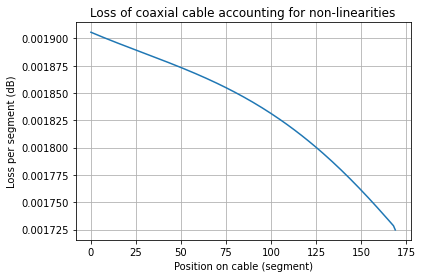

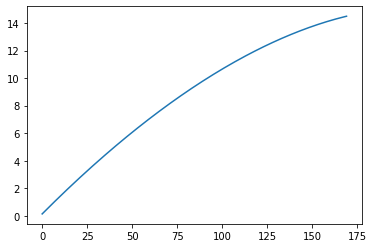

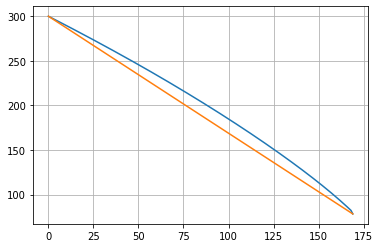

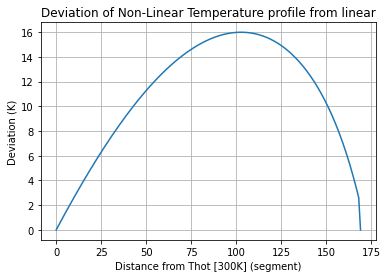

In [ ]:
interval = np.linspace(0, len(gradient_inner), len(gradient_inner))
linear_fit = np.poly1d(np.polyfit(interval, gradient_inner, 1))
linear_gradient = populateInitialState(300, 77, 0.059, len(gradient_inner))


plot = plt.figure()
ax = plt.axes()
ax.plot(y)
ax.set_xlabel("Position on cable (segment)")
ax.set_ylabel("Loss per segment (dB)")
ax.set_title("Loss of coaxial cable accounting for non-linearities")
plt.grid()
plot = plt.figure()
ax = plt.axes()
ax.plot(nTemp_array)
plot = plt.figure()
ax = plt.axes()
ax.plot(gradient_inner)
ax.plot(linear_gradient)
plt.grid()


deviation = []
for i in range(len(interval)):
  deviation.append((gradient_outer[i]-linear_gradient[i]))

plot = plt.figure()
ax = plt.axes()
plt.grid()
plt.plot(deviation)
ax.set_xlabel("Distance from Thot [300K] (segment)")
ax.set_ylabel("Deviation (K)")
ax.set_title("Deviation of Non-Linear Temperature profile from linear")

Calculator below to simplify calculating the noise using the code above. Dk is the Dk of the coaxial cable dielectric. The electrical condonductor is assumed to be BeCu and is calculated using NIST data. N_seg is the minimum number of segments (the number of segments the model starts iterating with). This calculator is outdated, please use example code above for best results.

In [ ]:
#Created by Ron Freeman 2021. All rights reserved.
#Lessons learned:
# - verify equations found online
# - use SI standard units to avoid confusion later on
#     - apply conversion factors in the function
# - use published coax data to verify the model


import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
#units are m, K, dB, W*m/K
ConductivityOfCopperSI = 5.98e+7
ConductivityOfCopperIACS = 100.0
PermeabilityOfFreeSpace = 4*np.pi*1E-7

#thermodynamics utility equations
def R_tCalc(delta_L, t_conduct, areaConduct):
  return delta_L/(t_conduct*areaConduct)

def R_tCalc_wTemp (delta_L, t_conduct, areaConduct, temp):
  return delta_L/(t_conduct(temp)*areaConduct)

def area_calc(Dout, Dinner):
  return np.pi*pow(Dout/2,2)-np.pi*pow(Dinner/2, 2)

def HeatFlowTotal(Thot, Tcold, R_t_int, L, a):
  return ((Thot-Tcold)*a)/(R_t_int*L)



#utility functions to calculate loss
def AdB_calc(R_m, z_0, Dout, Dinner, L): #R_m is skin resistance
  return (1.38*(R_m/z_0)*((1/Dout)+(1/Dinner)))*L

def AdB_calcv2(R_m_out, R_m_inner, z_0, Dout, Dinner, L): #R_m is skin resistance
  return (1.38*(1/z_0)*((R_m_out/Dout)+(R_m_inner/Dinner)))*L

def AdB_calcv3(e_cond_inner, perm_inner, e_cond_outer, perm_outer, Dinner, Douter, Dk, f, Z0):
  Res_per_len = (8.686/(2*138))*np.sqrt((f*PermeabilityOfFreeSpace*Dk)/np.pi)*((np.sqrt(e_cond_outer*perm_outer)/Douter)+(np.sqrt(e_cond_inner*perm_inner)/Dinner))*1/(np.log10(Douter/Dinner))
  loss_per_len = Res_per_len/(2*Z0)
  return loss_per_len

def R_m_calc(f, e_cond_cu, e_cond): #not sure what e_cond_cu is (the sigma_cu in equation 7) NOTES: sigma_cu is the electrical conductivity of copper at room temperature (constant). The other conductivity is the conductivity of the conductor (either copper inner conductor or ss outer conductor) 
  return 0.0034*np.sqrt(f)*np.sqrt(e_cond_ref/(1/e_cond))

def Z0_calc(epsilon, Dout, Dinner):
  return (138/np.sqrt(epsilon))*np.log10(Dout/Dinner)

def nTemp_calc(NF, Tcold, Tgradient):#Tp is the temperature of the device, G is the gain, NF is the noise figure
  p_ratio_calc =lambda NFr: 1/pow(10, NFr/10)
  total_noise_in = Tcold*p_ratio_calc(NF[0])
  total_noise_nseg = 0
  prod = []
  for i in range(len(NF)):
    prod.append(p_ratio_calc(NF[i]))
  for i in range(len(NF)):
    total_noise_nseg = total_noise_nseg + Tgradient[i]*(1-p_ratio_calc(NF[i]))
  #return total_noise_in+total_noise_nseg*np.prod(prod)
  return total_noise_nseg*np.prod(prod), total_noise_in+total_noise_nseg*np.prod(prod)

def NF_calc(loss):
  return 10*np.log10(pow(10,loss/10))

def innerConductorLoss(dInner, f, dk, Tgradient, e_cond): #frequency in gigahertz
  final = []
  wav_len = 2.99e+8/(np.sqrt(Dk)*f*1e+9)
  for i in range(len(Tgradient)):
    final.append((e_cond(Tgradient[i]))/(wav_len*np.pi*2*(dInner+wav_len*(np.exp(-dInner/wav_len)-1))))
  return final


#approximating the resistivity given temperature using NIST data
# https://srd.nist.gov/JPCRD/jpcrd155.pdf

T0_cu = np.array([1, 4, 7, 10, 15, 20 ,25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100, 125, 150, 175, 200, 225, 250, 273.15, 293, 300, 350, 400, 500, 600, 700, 800])
r0_cu = np.array([0.002, 0.002, 0.002, 0.00202, 0.00218, 0.00280, 0.00449, 0.00828, 0.0147, 0.0239, 0.0358, 0.0518, 0.0727, 0.0971, 0.154, 0.215, 0.281, 0.348, 0.522, 0.699, 0.874, 1.046, 1.217, 1.387, 1.543, 1.678, 1.725, 2.063, 2.402, 3.090, 3.792, 4.514, 5.262])*1e-8

e_cond_cu = np.polynomial.chebyshev.Chebyshev.fit(T0_cu[:-7],r0_cu[:-7],4) #fitting the conductivity to a 4th degree polynomial
#plt.figure()
#plt.plot(T0[:-7], (r0_cu[:-7]-e_cond_cu(T0[:-7]))) #plots error in the approximation within 1% accuracy

#resistivity of BeCu
e_cond_BeCu = lambda x: 8.31*1e-8+x*0
T0_BeCu_cond = [273, 192, 75.8, 19.6, 4]
r0_BeCu_C17200 = np.array([105.1, 96.8, 84.9, 81.8, 82.1])*1e-9
e_cond_BeCu_C17200 = np.polynomial.chebyshev.Chebyshev.fit(T0_BeCu_cond, r0_BeCu_C17200, 4)

#approimating electrical resistivity of 304 stainless steel
T0_SUS304 = np.array([2,3,4,5,6,7,8,9,10,12,14,16,18,20,25,30,35,40,45,50,60,70,80,90,100,150,200,250,300,400,500, 600,700,800])
r0_SUS304 = np.array([593, 593, 593, 594,594,594,594,594,594,594,594,593,593,593,592,592,593,595,597,599,606,613,622,630,639,683,724,767,810,885,944,997,1045,1088])*1e-9

e_cond_SUS304 = np.polynomial.chebyshev.Chebyshev.fit(T0_SUS304[:-7],r0_SUS304[:-7],4) #fitting the conductivity to a 4th degree polynomial

#approximating thermal resistance from the heat flow of coax
T0_coax = [188.5, 48.5, 12]
q_coax_SS_BeCu_data = [3.55e-5, 1.86e-5, 1.44e-6] #W/cmK coax 0.085 diameter
q_coax_SS_BeCu_data2 = [3.55e-1, 1.86e-1, 1.44e-2] #W/cmK coax 0.085 diameter
q_coax_SS_BeCu = np.polynomial.chebyshev.Chebyshev.fit(T0_coax,q_coax_SS_BeCu_data2,2) #fitting the conductivity to a 2nd degree polynomial
"""""
y = []
for i in range(len(T0_coax)):
  y.append(q_coax_SS_BeCu(T0_coax[i]))
plt.figure()
plt.plot(T0_coax, y)
"""""

#approximating the thermal conductivity of stainless steel (304)
T0_SUS304 = [40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300]
tConduct_SUS304_data = np.array([4.670, 5.730, 6.647, 7.435, 8.114, 8.705, 9.224, 10.101, 10.834, 11.479, 12.071, 12.633, 13.178, 13.714, 14.247, 14.779, 15.309])
tConduct_SUS304 = np.polynomial.chebyshev.Chebyshev.fit(T0_SUS304, tConduct_SUS304_data, 4) #fitting the conductivity to a 4th degree polynomial
tConduct_SUS304_integral = np.polynomial.chebyshev.chebint(tConduct_SUS304)

#approximating the thermal conductivity of BeCu and specific heat https://nvlpubs.nist.gov/nistpubs/Legacy/MONO/nistmonograph177.pdf, C17510
T0_BeCu = [76, 77.2, 78.46, 96, 106, 192.7, 215.4, 276, 284, 299]
tConduct_BeCu_data = np.array([132.5, 133, 133.5, 146.7, 153.6, 202.4, 213.5, 232.5, 235.4, 230]) #not sure this is correct
"""
T0_BeCu = [50, 60, 70, 80, 90, 100, 120, 300]
tConduct_BeCu_data = np.array([26.2, 30.42, 34.08, 37.15, 39.6, 41.41, 43.12, 85])
"""
tConduct_BeCu = np.polynomial.chebyshev.Chebyshev.fit(T0_BeCu, tConduct_BeCu_data, 4) #fitting the conductivity to a 4th degree polynomial
tConduct_BeCu_integral = np.polynomial.chebyshev.chebint(tConduct_BeCu)

T0_BeCu_SpecificHeat = [83.2, 99.4, 113, 125, 143, 182, 212, 242, 273, 297, 345]
SpecificHeat_BeCu_data = [226, 261, 269, 297, 328, 359, 371, 361, 391, 396, 404]
SpecificHeat_BeCu = np.polynomial.chebyshev.Chebyshev.fit(T0_BeCu_SpecificHeat, SpecificHeat_BeCu_data, 4)
e_cond_ref = (ConductivityOfCopperSI) 



#1D thermal solver using the FD method
def populateInitialState(Thot, Tcold, L, n_seg):
  y = lambda x : x*(Tcold-Thot)/L + Thot
  t = []
  for i in range(n_seg):
    t.append(y(i*(L/n_seg)))
  return t

def sigDiff(a, b, thresh):
  assert len(a) == len(b)
  for i in range(len(a)):
    if not abs(a[i]-b[i]) <= thresh:
      return False
  return True

def OneDFiniteThermalSolver_withResistancev4(Thot, Tcold, thresh, L, n_seg_i, t_conduct_outer, t_conduct_inner, Dout, Dout_in, Dinner):
  n_seg = n_seg_i
  bar_inner = populateInitialState(Thot, Tcold, L, n_seg)
  bar_outer = populateInitialState(Thot, Tcold, L, n_seg)
  final_inner= distribute_withResistancev3(bar_inner, L, n_seg, t_conduct_inner, np.pi*(Dinner/2)**2)
  final_outer = distribute_withResistancev3(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
  counter = 0
  while not sigDiff(bar_inner, final_inner, thresh):
    if counter > 100:
      n_seg = n_seg + 10
      bar_inner = populateInitialState(Thot, Tcold, L, n_seg)
      final_inner= distribute_withResistancev3(bar_inner, L, n_seg, t_conduct_inner, np.pi*(Dinner/2)**2)
      counter = 0
    else:
      bar_inner = final_inner
      final_inner= distribute_withResistancev3(bar_inner, L, n_seg, t_conduct_inner, np.pi*(Dinner/2)**2)
      counter = counter + 1
  n_seg = n_seg_i
  counter = 0
  while not sigDiff(bar_outer, final_outer, thresh):
    if counter > 100:
      n_seg = n_seg + 10
      bar_outer = populateInitialState(Thot, Tcold, L, n_seg)
      final_outer = distribute_withResistancev3(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
      counter = 0
    else:
      bar_outer = final_outer
      final_outer = distribute_withResistancev3(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
      counter = counter + 1
  if not len(final_inner) == len(final_outer):
    if len(final_inner) > len(final_outer):
      n_seg = len(final_inner)
      counter = 0
      bar_outer = populateInitialState(Thot, Tcold, L, n_seg)
      final_outer = distribute_withResistancev3(bar_outer, L, n_seg, t_conduct_outer, np.pi*(Dinner/2)**2)
      while counter < 100:
        bar_outer = final_outer
        final_outer = distribute_withResistancev3(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
        counter = counter + 1
    else:
      counter = 0
      n_seg = len(final_outer)
      bar_inner = populateInitialState(Thot, Tcold, L, n_seg)
      final_inner= distribute_withResistancev3(bar_inner, L, n_seg, t_conduct_inner, np.pi*(Dinner/2)**2)
      while counter < 100:
        bar_inner = final_inner
        final_outer = distribute_withResistancev3(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
        counter = counter + 1
  return final_inner, final_outer


  new = old[:]
  for i in range(1, len(old)-1):
    #new[i] = (old[i-1]+old[i+1])R_tCalc(L/n_seg, t_conduct, area)
    new[i] = (old[i-1]+old[i+1])*1/2
  return new

def distribute_withResistancev3(old, L, n_seg, t_conduct, area):
  new = old[:]
  R_total = 0
  for i in range(len(old)):
    R_total += (L/n_seg)/(t_conduct(old[i])*area)
  for i in range(1, n_seg-1):
    Q = (max(old)-min(old))/R_total
    DeltaT = Q*((L/n_seg)/(t_conduct(old[i-1])*area))
    new[i] = new[i-1]-DeltaT
  return new
###############
# Depreceated #
###############
def OneDFiniteThermalSolver_withResistancev3(Thot, Tcold, thresh, L, n_seg_i, t_conduct_inner, t_conduct_outer, Dout, Dout_in, Dinner):
  n_seg = n_seg_i
  bar_inner = populateInitialState(Thot, Tcold, L, n_seg)
  bar_outer = populateInitialState(Thot, Tcold, L, n_seg)
  final_inner= distribute_withResistancev2(bar_inner, L, n_seg, t_conduct_inner, np.pi*(Dinner/2)**2)
  final_outer = distribute_withResistancev2(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
  counter = 0
  while not sigDiff(bar_inner, final_inner, thresh):
    if counter > 100:
      n_seg = n_seg + 10
      bar_inner = populateInitialState(Thot, Tcold, L, n_seg)
      final_inner= distribute_withResistancev2(bar_inner, L, n_seg, t_conduct_inner, np.pi*(Dinner/2)**2)
      counter = 0
    else:
      bar_inner = final_inner
      final_inner= distribute_withResistancev2(bar_inner, L, n_seg, t_conduct_inner, np.pi*(Dinner/2)**2)
      counter = counter + 1
  n_seg = n_seg_i
  counter = 0
  while not sigDiff(bar_outer, final_outer, thresh):
    if counter > 100:
      n_seg = n_seg + 10
      bar_outer = populateInitialState(Thot, Tcold, L, n_seg)
      final_outer = distribute_withResistancev2(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
      counter = 0
    else:
      bar_outer = final_outer
      final_outer = distribute_withResistancev2(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
      counter = counter + 1
  if not len(final_inner) == len(final_outer):
    if len(final_inner) > len(final_outer):
      n_seg = len(final_inner)
      counter = 0
      bar_outer = populateInitialState(Thot, Tcold, L, n_seg)
      final_outer = distribute_withResistancev2(bar_outer, L, n_seg, t_conduct_outer, np.pi*(Dinner/2)**2)
      while counter < 100:
        bar_outer = final_outer
        final_outer = distribute_withResistancev2(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
        counter = counter + 1
    else:
      counter = 0
      n_seg = len(final_outer)
      bar_inner = populateInitialState(Thot, Tcold, L, n_seg)
      final_inner= distribute_withResistancev2(bar_inner, L, n_seg, t_conduct_inner, np.pi*(Dinner/2)**2)
      while counter < 100:
        bar_inner = final_inner
        final_outer = distribute_withResistancev2(bar_outer, L, n_seg, t_conduct_outer, (np.pi*(Dout/2)**2) - (np.pi*(Dout_in/2)**2))
        counter = counter + 1
  return final_inner, final_outer

def OneDFiniteThermalSolver(bar, thresh, L, n_seg, t_conduct, Dout, Dinner):
  final= distribute(bar, L, n_seg, t_conduct, area_calc(Dout, Dinner))
  while not sigDiff(bar, final, thresh):
    bar = final
    final = distribute(bar, L, n_seg, t_conduct, area_calc(Dout, Dinner))
  return final

def distribute(old, L, n_seg, t_conduct, area):
  new = old[:]
  for i in range(1, len(old)-1):
    #new[i] = (old[i-1]+old[i+1])R_tCalc(L/n_seg, t_conduct, area)
    new[i] = (old[i-1]+old[i+1])*1/2
  return new

def OneDFiniteThermalSolver_withResistance(Thot, Tcold, thresh, L, n_seg, t_conduct, Dout, Dinner):
  bar = populateInitialState(Thot, Tcold, L, n_seg)
  final= distribute_withResistancev2(bar, L, n_seg, t_conduct, area_calc(Dout, Dinner))
  counter = 0
  while not sigDiff(bar, final, thresh):
    if counter > 100:
      plot = plt.figure()
      ax = plt.axes()
      ax.plot(final)
      n_seg = n_seg + 10
      plot = plt.figure()
      ax = plt.axes()
      ax.plot(final)
      bar = populateInitialState(Thot, Tcold, L, n_seg)
      counter = 0
    else:
      bar = final
    final = distribute_withResistancev2(bar, L, n_seg, t_conduct, area_calc(Dout, Dinner))
    counter = counter + 1
  return final

def distribute_withResistancev2(old, L, n_seg, t_conduct, area):
  new = old[:]
  Q = HeatFlowTotal(max(old), min(old), R_tCalc(L/n_seg, t_conduct(mean(old)), area), L, area)
  for i in range(1, n_seg-1):
    #T2 = (T1(R2+R3)+T3(R1+R2))/(2*R2+R3+R1) where T2=T at n; T1 = T at n-1; and T3 = T at n+1
    new[i] = (old[i-1]*(R_tCalc(L/n_seg, t_conduct(old[i]), area)+R_tCalc(L/n_seg, t_conduct(old[i+1]), area))+old[i+1]*(R_tCalc(L/n_seg, t_conduct(old[i-1]), area)+R_tCalc(L/n_seg, t_conduct(old[i]), area)))/(2*R_tCalc(L/n_seg, t_conduct(old[i]), area)+R_tCalc(L/n_seg, t_conduct(old[i+1]), area)+R_tCalc(L/n_seg, t_conduct(old[i-1]), area))
  return new

def distribute_withResistance(old, L, n_seg, t_conduct, area):
  new = old[:]
  Q = HeatFlowTotal(max(old), min(old), R_tCalc(L/n_seg, t_conduct(mean(old)), area), n_seg)
  for i in range(0, n_seg):
    new[i] = old[i-1]-Q*R_tCalc(L/n_seg, t_conduct(old[i]), area)*i
  return new
def OneDFiniteThermalSolver_withResistance_constTconduct(Thot, Tcold, thresh, L, n_seg, t_conduct, Dout, Dinner):
  bar = populateInitialState(Thot, Tcold, L, n_seg)
  final= distribute_withResistance_constTconduct(bar, L, n_seg, t_conduct, area_calc(Dout, Dinner))
  while not sigDiff(bar, final, thresh):
    bar = final
    final = distribute_withResistance_constTconduct(bar, L, n_seg, t_conduct, area_calc(Dout, Dinner))
  return final
def distribute_withResistance_constTconduct(old, L, n_seg, t_conduct, area):
  new = old[:]
  Q = HeatFlowTotal(max(old), min(old), R_tCalc(L/n_seg, t_conduct, area), n_seg)
  for i in range(1, n_seg-1):
    new[i] = old[i-1]-Q*R_tCalc(L/n_seg, t_conduct, area)
  return new
###############
###############
###############




#1D noise solver factoring thermals (this approximates that loss=NF which is not valid when the noise is below -174 dBm/Hz) Source:http://www.ni.com/tutorial/6810/en/
PermeabilityOfFreeSpace = 4*np.pi*1E-7

def SkinDepth_calc(f, mu_R, e_cond): #e_cond in ohms/m
  return np.sqrt(e_cond/(np.pi*f*PermeabilityOfFreeSpace*mu_R))

def Z0_calc(epsilon, Dout, Dinner):
  return (138/np.sqrt(epsilon))*np.log10(Dout/Dinner)

def InnerCondArea(Dinner, skin_d):
  return 2*np.pi*skin_d*(Dinner+skin_d*(np.exp(-Dinner/skin_d)-1))

def OutCondArea(Dout, Dout_i, skin_d):
  return 2*np.pi*skin_d*(Dout_i+skin_d-(Dout+skin_d)*np.exp((Dout_i-Dout)/skin_d))

def CondLoss(rho, area, Z0): #now units ohms/m, returns loss in db per len
  return (8.686*(rho/area))/(2*Z0)

def DielectricLoss_calc(f, epsilon, skin_d, wave_len):
  return (27.28753*np.sqrt(epsilon)*np.tan(skin_d))/wave_len

"""
Inputs:
[skin_d] Skin depth in m
[roughness_rms] RMS surface roughness of conductor, delta from equation cited

Outputs:
Adjustment factor to correct effective area for changes due to surface roughness
"""
def SurfaceRoughnessFactor(roughness_rms, skin_d): #source for this equation is https://www.microwaves101.com/encyclopedias/surface-roughness which cites A Microstrip Handbook, ELAB Report, STF 44 A74169, University of Trondheim, Norway, 1975, pp 98-110
  return 1 + (2/np.pi)*np.arctan(1.4*(roughness_rms/skin_d)**2)

def OneDFiniteEMNoiseSolverv4(T_gradient_inner, T_gradient_outer, f, e_cond_outer, mu_outer, e_cond_inner, mu_inner, Dk, Dout, Dout_i, Dinner, L):
  assert len(T_gradient_inner) == len(T_gradient_outer)
  #first find loss from the inner conductor
  loss_inner = []
  for i in range(len(T_gradient_inner)):
    loss_inner.append(CondLoss(e_cond_inner(T_gradient_inner[i]), InnerCondArea(Dinner, SkinDepth_calc(f, mu_inner, e_cond_inner(T_gradient_inner[i]))), Z0_calc(Dk, Dout, Dinner))*L/len(T_gradient_inner))

  #now find loss from outer conductor
  loss_outer = []
  for i in range(len(T_gradient_outer)):
    loss_outer.append(CondLoss(e_cond_outer(T_gradient_outer[i]), OutCondArea(Dout, Dout_i, SkinDepth_calc(f, mu_outer, e_cond_outer(T_gradient_outer[i]))), Z0_calc(Dk, Dout, Dinner))*L/len(T_gradient_outer))

  #Now also include dielectric losses
  dielectric_loss = []
  for i in range(len(T_gradient_inner)):
    dielectric_loss.append(DielectricLoss_calc(f, Dk, SkinDepth_calc(f, mu_inner, e_cond_inner(T_gradient_inner[i])), 3e+8/(f*np.sqrt(Dk)))*L/len(T_gradient_inner))

  res = dielectric_loss[:]
  for i in range(len(T_gradient_outer)):
    res[i] = loss_outer[i]+loss_inner[i]+dielectric_loss[i]

  return res, mean(res)/(L/len(T_gradient_outer)), mean(loss_inner)/(L/len(T_gradient_outer)), mean(loss_outer)/(L/len(T_gradient_outer)), mean(dielectric_loss)/(L/len(T_gradient_outer))

def OneDFiniteEMNoiseSolverv4_withSurfaceRoughness(T_gradient_inner, T_gradient_outer, f, rms_roughness_outer, e_cond_outer, mu_outer, rms_roughness_inner, e_cond_inner, mu_inner, Dk, Dout, Dout_i, Dinner, L):
  assert len(T_gradient_inner) == len(T_gradient_outer)
  #first find loss from the inner conductor
  loss_inner = []
  for i in range(len(T_gradient_inner)):
    loss_inner.append(CondLoss(e_cond_inner(T_gradient_inner[i]), InnerCondArea(Dinner, SkinDepth_calc(f, mu_inner, e_cond_inner(T_gradient_inner[i]))), Z0_calc(Dk, Dout, Dinner))*L/len(T_gradient_inner)*SurfaceRoughnessFactor(rms_roughness_inner, SkinDepth_calc(f, mu_inner, e_cond_inner(T_gradient_inner[i]))))

  #now find loss from outer conductor
  loss_outer = []
  for i in range(len(T_gradient_outer)):
    loss_outer.append(CondLoss(e_cond_outer(T_gradient_outer[i]), OutCondArea(Dout, Dout_i, SkinDepth_calc(f, mu_outer, e_cond_outer(T_gradient_outer[i]))), Z0_calc(Dk, Dout, Dinner))*L/len(T_gradient_outer)*SurfaceRoughnessFactor(rms_roughness_outer, SkinDepth_calc(f, mu_outer, e_cond_outer(T_gradient_outer[i]))))

  #Now also include dielectric losses
  dielectric_loss = []
  for i in range(len(T_gradient_inner)):
    dielectric_loss.append(DielectricLoss_calc(f, Dk, SkinDepth_calc(f, mu_inner, e_cond_inner(T_gradient_inner[i])), 3e+8/(f*np.sqrt(Dk)))*L/len(T_gradient_inner))

  res = dielectric_loss[:]
  for i in range(len(T_gradient_outer)):
    res[i] = loss_outer[i]+loss_inner[i]+dielectric_loss[i]

  return res, mean(res)/(L/len(T_gradient_outer)), mean(loss_inner)/(L/len(T_gradient_outer)), mean(loss_outer)/(L/len(T_gradient_outer)), mean(dielectric_loss)/(L/len(T_gradient_outer))

###############
# Depreceated #
###############
def OneDFiniteEMNoiseSolver(T_gradient, f_ghz, e_cond, epsilon, Dout, Dinner, L): #calculates the noise temperature of each segment in the transmission line given a temperature gradient and parameters (length in cm)
  noise_final = []
  for i in range(len(T_gradient)):
    noise_final.append(AdB_calc(R_m_calc(f_ghz, e_cond_ref, e_cond(T_gradient[i])), Z0_calc(epsilon, Dout, Dinner), Dout, Dinner, L/len(T_gradient)))
  return noise_final, mean(noise_final)/(L/len(T_gradient))

def TotalNoise(noise, gain):
  # return Nin*np.prod(gain)+sum(noise)*(1/gain[-1] - 1)*np.prod(gain)
  gainTotal = []
  for i in range(len(noise)):
    gainTotal.append(gain) 
  return sum(noise)*(1/gainTotal[-1] - 1)*np.prod(gainTotal)

def TotalNoisev2(noise):
  return sum(noise)


def OneDFiniteEMNoiseSolverv2(T_gradient_inner, T_gradient_outer, f_ghz, e_cond_outer, e_cond_inner, epsilon, Dout, Dinner, L): #calculates the noise temperature of each segment in the transmission line given a temperature gradient and parameters (length in cm)
  noise_final = []
  assert len(T_gradient_inner) == len(T_gradient_outer)
  for i in range(len(T_gradient_inner)):
    noise_final.append(AdB_calcv2(R_m_calc(f_ghz, e_cond_ref, e_cond_outer(T_gradient_outer[i])), R_m_calc(f_ghz, e_cond_ref, e_cond_inner(T_gradient_inner[i])), Z0_calc(epsilon, Dout, Dinner), Dout, Dinner, L/len(T_gradient_inner)))
  return noise_final, mean(noise_final)/(L/len(T_gradient_inner))

def OneDFiniteEMNoiseSolverv3(T_gradient_inner, T_gradient_outer, f_ghz, e_cond_outer, perm_outer, e_cond_inner, perm_inner, epsilon, Dout, Dinner, L):
  noise_final = []
  assert len(T_gradient_inner) == len(T_gradient_outer)
  for i in range(len(T_gradient_inner)):
    noise_final.append(AdB_calcv3(e_cond_inner(T_gradient_inner[i]), perm_inner, e_cond_outer(T_gradient_outer[i]), perm_outer, Dinner, Dout, epsilon, f_ghz*1e+9, Z0_calc(epsilon, Dout, Dinner))*(L/len(T_gradient_inner)))
  return noise_final, mean(noise_final)/(L/len(T_gradient_inner))
###############
###############
###############



#@title Cryogenic Coax Loss Calculator [units are cm, Hz, K, W*m/K]
Thot = 300 #@param {type:"raw"}
Tcold = 77 #@param {type:"raw"}
Length =  5.9#@param {type:"raw"}
n_seg =  170#@param {type:"raw"}
coax_initial = [Thot, Tcold]
D_inner = 0.051 #@param {type:"raw"}
D_outer = 0.194 #@param {type:"raw"}
D_outer_inner = 0.168 #@param {type:"raw"}
Dk = 2.1 #@param {type:"raw"}
Frequency =  1.4e+9#@param {type:"raw"}
Threshold = 0.001 #@param {type: "raw"}
e_cond_inner = e_cond_SUS304 #@param ["e_cond_cu", "e_cond_BeCu_C17200", "e_cond_SUS304"] {type:"raw"}
mu_inner = 1.005 #@param {type: "raw"}
RMS_SurfaceRoughness_inner =  10#@param {type: "raw"}
t_cond_inner = tConduct_SUS304 #@param ["tConduct_BeCu", "tConduct_SUS304"] {type:"raw"}
e_cond_outer = e_cond_SUS304 #@param ["e_cond_cu", "e_cond_BeCu_C17200", "e_cond_SUS304"] {type:"raw"}
mu_outer =  1.005#@param {type: "raw"}
RMS_SurfaceRoughness_outer =  15#@param {type: "raw"}
t_cond_outer = tConduct_SUS304 #@param ["tConduct_BeCu", "tConduct_SUS304"] {type:"raw"}
correction_factor = 1 #@param {type: "raw"}

gradient_inner, gradient_outer = np.array(OneDFiniteThermalSolver_withResistancev4(Thot, Tcold, Threshold, Length*1e-2, n_seg, t_cond_outer, t_cond_inner, D_outer*1e-2, D_outer_inner*1e-2, D_inner*1e-2)) #units now in meters!!!!
y, t, loss_inner, loss_outer, dielectric_loss = OneDFiniteEMNoiseSolverv4_withSurfaceRoughness(gradient_inner, gradient_outer, Frequency, RMS_SurfaceRoughness_outer*1e-6, e_cond_outer, mu_outer, RMS_SurfaceRoughness_inner*1e-6, e_cond_inner, mu_inner, Dk, D_outer*1e-2, D_outer_inner*1e-2, D_inner*1e-2, Length*1e-2) #units in m, Hz, ohm/m, K
#y, t, loss_inner, loss_outer, dielectric_loss = OneDFiniteEMNoiseSolverv4(gradient_inner, gradient_outer, Frequency, e_cond_outer, mu_outer, e_cond_inner, mu_inner, Dk, D_outer*1e-2, D_outer_inner*1e-2, D_inner*1e-2, Length*1e-2) #units in m, Hz, ohm/m, K
noise_cable, noise_total = nTemp_calc(y, Tcold, gradient_inner)
print("Total Noise of cable:", correction_factor*noise_cable)
print("Total Noise of the System (77K in)", noise_total)

print("")
print("Total loss (dB):", correction_factor*sum(y))
print("Average Composite Loss in dB/m:", correction_factor*t)
print("Average Inner Conductor Loss in dB/m:", correction_factor*loss_inner)
print("Average Outer Conductor Loss in dB/m:", correction_factor*loss_outer)
print("Average Dielectric Loss in dB/m:", correction_factor*dielectric_loss)


Total Noise of cable: 8.471468079466835
Total Noise of the System (77K in) 85.45098483053383

Total loss (dB): 0.190928010509834
Average Composite Loss in dB/m: 3.2360679747429484
Average Inner Conductor Loss in dB/m: 2.415279722988539
Average Outer Conductor Loss in dB/m: 0.8177496496743744
Average Dielectric Loss in dB/m: 0.003038602080035142
